In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

np.random.seed(1)

In [56]:
df = pd.read_csv('../Tutorial 1/ToyotaCorolla.csv')

df = df.drop(columns=['Id', 'Model', 'Mfg_Month', 'Mfg_Year', 'Cylinders']) #, 'Doors'])
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
df['Color'] = df['Color'].astype('category')
# df['Gears'] = df['Gears'].astype('category')
# df['Doors'] = df['Doors'].astype('category')

np.random.seed(1)
df.rename(columns={'Age_08_04': 'Age'}, inplace=True)

# binary_features = [col for col in df.columns if df[col].nunique == 2]

for col in df.columns:
    if df[col].nunique() == 2:
        df[col] = df[col].astype('bool')

df = pd.get_dummies(df, drop_first=True)

df.loc[df['CC'] == 16000, 'CC'] = 1600

In [70]:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_features.remove('Price')
print(numeric_features)

['Age', 'KM', 'HP', 'CC', 'Doors', 'Gears', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']


In [37]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=1)

In [89]:
X = df_train[['Age']]
y = df_train['Price']

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

m = pipe.fit(X, y)

print(f"Coefficient Age: {m[1].coef_[0]:.4f}, Intercept: {m[1].intercept_:.4f}")

Coefficient Age: -3163.4678, Intercept: 10739.3593


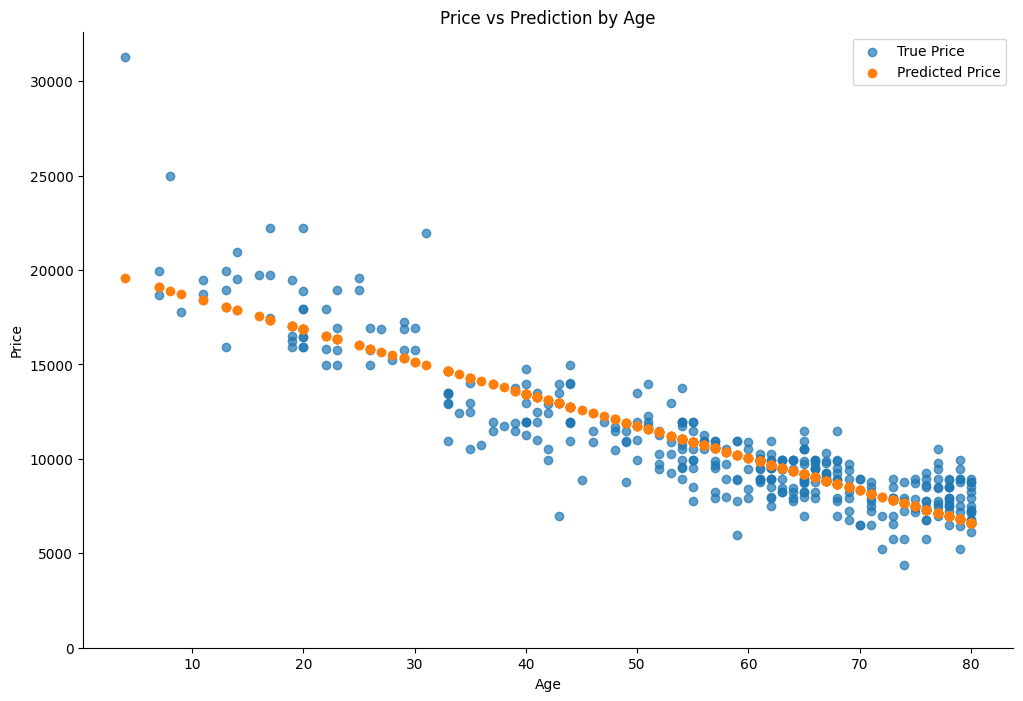

In [96]:
pred = m.predict(df_test[['Age']])
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter('Age', 'Price', data=df_test, label='True Price', alpha=0.7)
ax.scatter(df_test['Age'], pred, label='Predicted Price')
ax.set_title("Price vs Prediction by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0)
ax.legend()
plt.plot();

The model performs bad for small values of `Age`.
The figure exhibits heteroskedasticity and some indications of endogeneity.

In [101]:
m.score(df_test[['Age']], df_test['Price'])

0.7932759309926051

In [103]:
r2_scores = cross_val_score(m, df_test[['Age']], df_test['Price'], cv=5, scoring='r2')
print(r2_scores)
print(f"Mean: {r2_scores.mean():.4f}  Std: {r2_scores.std():.4f}")

[0.75879191 0.79229358 0.82387476 0.80075358 0.76560367]
Mean: 0.7883  Std: 0.0238


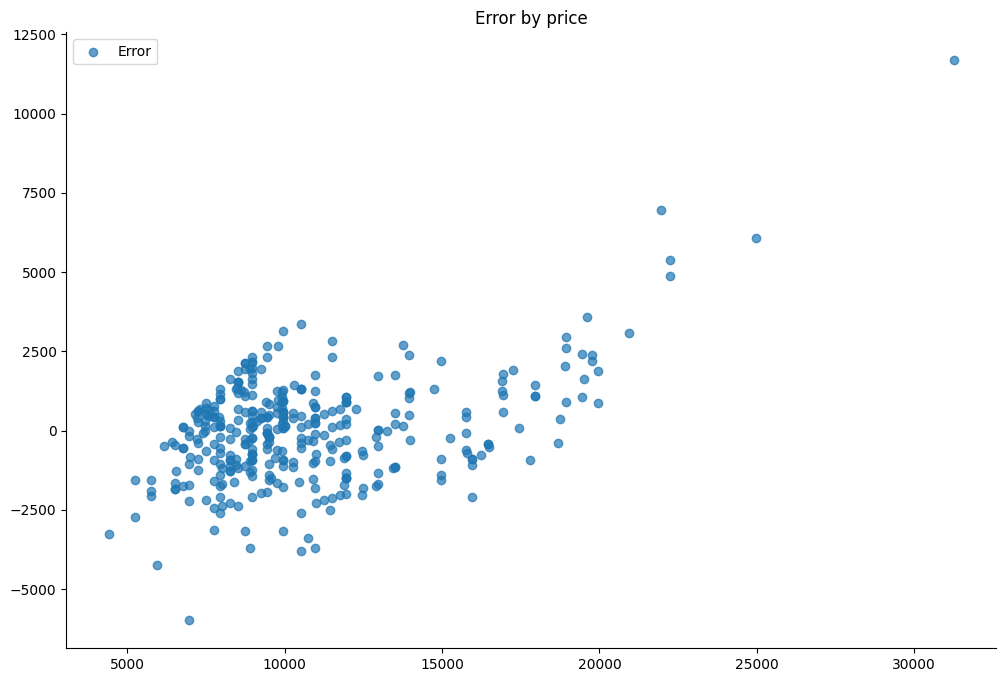

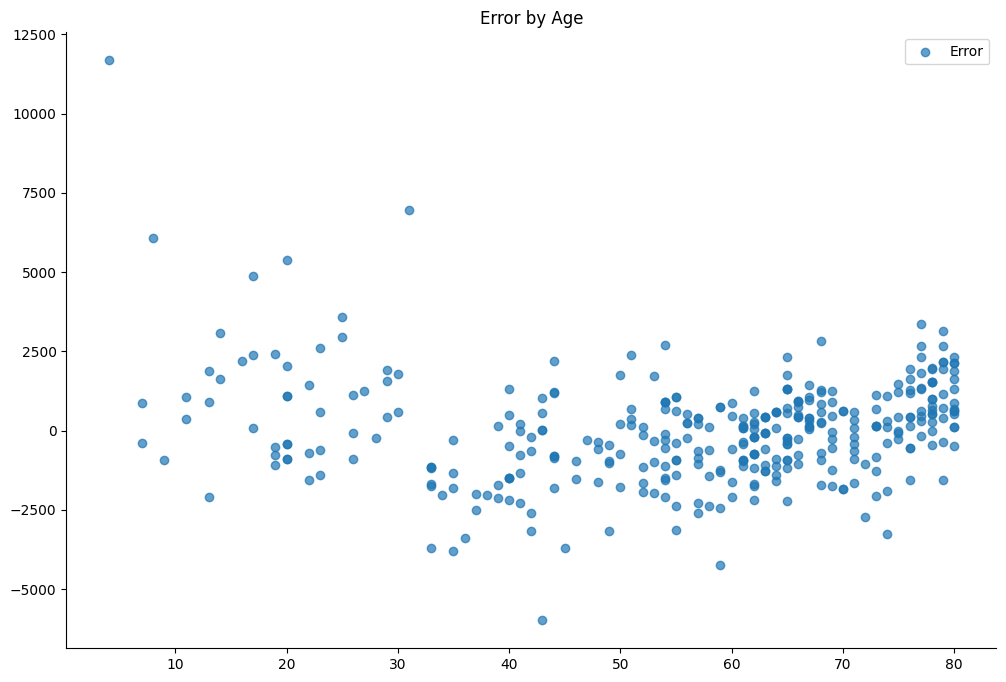

In [99]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df_test['Price'], df_test['Price'] - pred, label='Error', alpha=0.7)
ax.set_title("Error by price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.plot();

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df_test['Age'], df_test['Price'] - pred, label='Error', alpha=0.7)
ax.set_title("Error by Age")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.plot();

Regression on all coefficients:

In [64]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

m1 = pipe.fit(df_train.drop(columns='Price'), df_train['Price'])

print("Estimated Coefficients:")

for i, name in enumerate(m1[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m1[1].coef_[i]:>10.4f}", end='\t')
print()


Estimated Coefficients:

Age                 -2111.7953	KM                   -609.0737	HP                    814.1528	Met_Color             -24.8165	
Automatic             119.6264	CC                   -691.0416	Doors                  88.9612	Gears                   0.3494	
Quarterly_Tax         622.3601	Weight                475.2576	Mfr_Guarantee         111.3777	BOVAG_Guarantee       116.1520	
Guarantee_Period      206.6480	ABS                   -68.7350	Airbag_1               -8.1352	Airbag_2              -79.1652	
Airco                 118.4427	Automatic_airco       580.0461	Boardcomputer        -144.8889	CD_Player              99.8999	
Central_Lock           41.6818	Powered_Windows       123.6255	Power_Steering         21.9746	Radio                 -85.1887	
Mistlamps               5.6817	Sport_Model           151.8074	Backseat_Divider      -70.7436	Metallic_Rim           97.5678	
Radio_cassette         60.5753	Parking_Assistant     -38.5953	Tow_Bar               -40.0648	Fuel_Ty

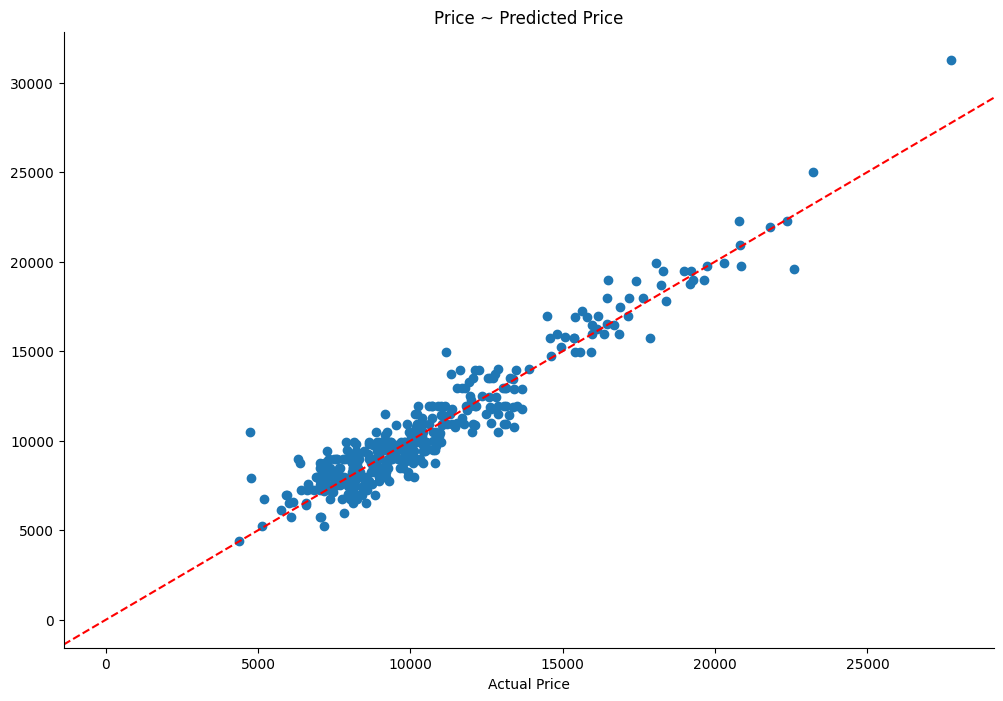

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(m1.predict(df_test.drop(columns='Price')), df_test['Price'])
ax.set_title("Price ~ Predicted Price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Predicted Price")
ax.set_xlabel("Actual Price")

ax.axline((0, 0), slope=1, color='r', linestyle='--')
plt.plot();

We're doing pretty well.

I changed the CC to 1600 in the df generation code block.
Judging by the weight it is not a monster truck, I think it is fair.

In [47]:
m1.score(df_test.drop(columns='Price'), df_test['Price'])

0.9074910119828293

In [50]:
r2_scores = cross_val_score(estimator=m1, df_test.drop(columns='Price'), df_test['Price'], cv=5, scoring='r2')
print(r2_scores)
print(f"Mean: {r2_scores.mean():.4f}  Std: {r2_scores.std():.4f}")

[0.93816886 0.86098754 0.9220295  0.88770892 0.88507701]
Mean: 0.8988  Std: 0.0277


In [80]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_features)
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

m2 = pipe.fit(df_train.drop(columns='Price'), df_train['Price'])

print("Estimated Coefficients:")

for i, name in enumerate(m2[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m2[1].coef_[i]:>10.4f}", end='\t')
print()

Estimated Coefficients:

Age                 -2111.7953	KM                   -609.0737	HP                    814.1528	Met_Color            -691.0416	
Automatic              88.9612	CC                      0.3494	Doors                 622.3601	Gears                 475.2576	
Quarterly_Tax         206.6480	Weight                -52.9462	Mfr_Guarantee         509.7454	BOVAG_Guarantee       226.6581	
Guarantee_Period      379.0223	ABS                  -175.4170	Airbag_1              -49.4368	Airbag_2             -178.2758	
Airco                 236.9304	Automatic_airco      2453.4855	Boardcomputer        -316.2014	CD_Player             241.5054	
Central_Lock           84.7941	Powered_Windows       249.8521	Power_Steering        148.8730	Radio                -243.3530	
Mistlamps              12.7537	Sport_Model           332.4900	Backseat_Divider     -169.2454	Metallic_Rim          238.4551	
Radio_cassette        173.9878	Parking_Assistant    -732.2979	Tow_Bar               -89.9341	Fuel_Ty

Oh only on age? I should've read better.

In [83]:
# yhat = m1.predict(df_test.drop(columns='Price'))

# horrible = df_test.iloc[np.where(yhat < 0)]

# # m1.predict(horrible.drop(columns='Price'))

# horrible.T

# The CC is insane. Should probably be 1600. 
# Also, wouldn't it make more sense for CC to have a positive coefficient?